# Projet denoising - DLTS MVA 2023/24 - David FAGET et Biel CASTAÑO

# Importation des librairies

In [ ]:
!pip install IPython
!pip install librosa
!pip install pesq
!pip install pystoi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=262923 sha256=9dba9d96df98f485b4edbed6e58e4ce78063cb26ef786b567baf700cb4eca412
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq


In [ ]:
import numpy as np
import torch
from itertools import permutations
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import random
import IPython.display as ipd
import os
import torchaudio
from scipy.io import wavfile
import json
import librosa
from pesq import pesq
from pystoi import stoi
from itertools import permutations
import gc

# Chargement des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Chemins des fichiers pour chaque ensemble
noise_trainsmall_path = "/content/drive/MyDrive/denoising_dlts/denoising/train_small"
noise_train_path = "/content/drive/MyDrive/denoising_dlts/denoising/train"
noise_test_path = "/content/drive/MyDrive/denoising_dlts/denoising/test"

original_trainsmall_path = "/content/drive/MyDrive/denoising_dlts/voice_origin/train_small"
original_train_path = "/content/drive/MyDrive/denoising_dlts/voice_origin/train"
original_test_path = "/content/drive/MyDrive/denoising_dlts/voice_origin/test"

## Création du dataset et du dataloader

In [ ]:
class WAVDataset(Dataset):
    def __init__(self, noise_folder_path, original_folder_path, L=40):
        self.noise_files = [os.path.join(noise_folder_path, f) for f in os.listdir(noise_folder_path) if f.endswith('.wav')]
        self.original_files = [os.path.join(original_folder_path, f) for f in os.listdir(original_folder_path) if f.endswith('.wav')]

        # On les met dans l'ordre croissant de chiffres (Partie, Chapitre, Numéro) pour s'assurer qu'il y ait une correspondance entre les
        # originaux et les bruités (en important les données sur Drive, l'ordre a changé):

        def extraire_numeros(fichier):
            # Diviser le nom du fichier en parties
            parties = fichier.split('_')
            # Trouver l'index de l'élément qui commence par "Partie"
            index_partie = next(i for i, part in enumerate(parties) if part.startswith("Partie"))
            # Trouver l'index de l'élément qui commence par "Chap"
            index_chap = next(i for i, part in enumerate(parties) if part.startswith("Chap"))
            # Extraire le numéro de partie, de chapitre et de fichier
            num_partie = int(parties[index_partie][6:])  # Extrait le numéro après "Partie"
            num_chapitre = int(parties[index_chap][4:])  # Extrait le numéro après "Chap"
            num_fichier = int(parties[-2])  # Extrait le numéro à la fin
            return (num_partie, num_chapitre, num_fichier)

        # Trier les fichiers en fonction du numéro extrait
        self.noise_files = sorted(self.noise_files, key=extraire_numeros)
        self.original_files = sorted(self.original_files, key=extraire_numeros)
        self.L = L


    def __len__(self):
        return len(self.noise_files) # Les fichiers noisy et originaux ont la même longueur

    def __getitem__(self, idx):
        noise_path = self.noise_files[idx]
        original_path = self.original_files[idx]

        noise_rate, noise_data = wavfile.read(noise_path)
        original_rate, original_data = wavfile.read(original_path)

        # Diviser les audios en K segments
        K = int(np.ceil(len(noise_data) / self.L))
        pad_len = K * self.L

        # Zero Pad pour avoir une longueur K*L
        pad_noise = np.concatenate([noise_data, np.zeros([pad_len - len(noise_data)])])
        pad_original = np.concatenate([original_data, np.zeros([pad_len - len(original_data)])])

        # Reshape pour avoir la forme [K,L]
        pad_noise = np.reshape(pad_noise, [K, self.L])
        pad_original = np.reshape(pad_original, [K, self.L])

        pad_noise = torch.from_numpy(pad_noise).float()
        pad_original = torch.from_numpy(pad_original).float()

        return noise_data, original_data, noise_rate, original_rate, pad_noise, pad_original

def _collate_fn(batch):
    _, _, batch_noise_rate, batch_original_rate, batch_noise_pad, batch_original_pad = zip(*batch)
    ilens = np.array([noise.shape[0] for noise in batch_noise_pad])

    max_len = max([noise.shape[0] for noise in batch_noise_pad])
    pad_value = 0
    batch_noise_pad = torch.stack([torch.nn.functional.pad(noise, (0, 0, 0, max_len - noise.shape[0]), value=pad_value) for noise in batch_noise_pad])
    batch_original_pad = torch.stack([torch.nn.functional.pad(original, (0, 0, 0, max_len - original.shape[0]), value=pad_value) for original in batch_original_pad])
    ilens = torch.from_numpy(ilens)

    batch_sources = torch.stack([batch_original_pad, batch_noise_pad - batch_original_pad], dim=1)

    return batch_noise_pad, ilens, batch_sources


# On crée un dataset pour chaque ensemble de données:

#Train_small
trainsmall_dataset = WAVDataset(noise_trainsmall_path, original_trainsmall_path)
train_dataset = WAVDataset(noise_train_path, original_train_path)
test_dataset = WAVDataset(noise_test_path, original_test_path)

# On crée un dataloader pour chaque ensemble de données:
num_workers = 4
batch_size = 10

trainsmall_dataloader = DataLoader(trainsmall_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, collate_fn=_collate_fn)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, collate_fn=_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, collate_fn=_collate_fn)

test_dataloader_tas = test_dataloader
test_dataset_tas = test_dataset


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Visualisation des données

## Taille

In [ ]:
print("Nombre total de fichiers train_small :", len(trainsmall_dataloader.dataset))
print("Nombre total de fichiers train :", len(train_dataloader.dataset))
print("Nombre total de fichiers test :", len(test_dataloader.dataset))

Nombre total de fichiers train_small : 10
Nombre total de fichiers train : 2118
Nombre total de fichiers test : 782


## On écoute quelques fichiers .wav sans bruit et autres avec du bruit

In [ ]:
nbre_exemples = 5

for i in range(nbre_exemples):
    print("-------------------------\n")
    print(f"Audio original nº{i+1}:")
    bruit, original, bruit_rate, original_rate, _, _ = trainsmall_dataset[i]
    ipd.display(ipd.Audio(original, rate = original_rate))
    print(f"Audio bruité nº{i+1}:")
    ipd.display(ipd.Audio(bruit, rate = bruit_rate))

-------------------------

Audio original nº1:


Audio bruité nº1:


-------------------------

Audio original nº2:


Audio bruité nº2:


-------------------------

Audio original nº3:


Audio bruité nº3:


-------------------------

Audio original nº4:


Audio bruité nº4:


-------------------------

Audio original nº5:


Audio bruité nº5:


Observation: L'audio bruité nº1 n'a presque pas de bruit de fond, alors que le nº5 est presque incompréhensible. Cela est donc bien un reflet de que le SNR varie d'un audio à un autre. Nous allons vérifier cela en observant la forme d'onde temporelle.

## Visualisation de l'onde temporelle et calcul du PESQ et STOI

Nous allons visualiser la forme d'onde temporelle des signaux écoutés ci-dessus et nous allons aussi calculer les métriques PESQ et STOI.

Le PESQ, norme internationale pour l'évaluation de la qualité de la parole, compare un signal vocal dégradé avec un signal de référence pour mesurer la qualité de la parole, avec un score allant de -0.5 à 4.5 où un score élevé indique une meilleure qualité. Le STOI, quant à lui, mesure l'intelligibilité de la parole en évaluant l'impact des modifications du signal vocal, comme le bruit ou la réverbération, avec un score entre 0 et 1 où 1 signifie une intelligibilité parfaite.

---------------------------------------------

Audio original nº1:


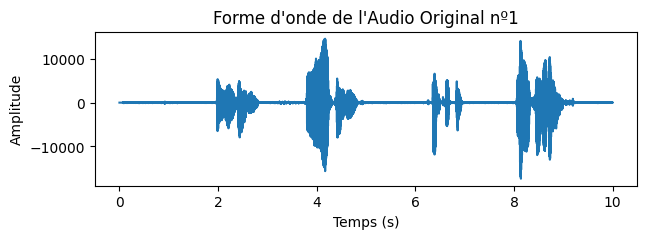

Audio bruité nº1:


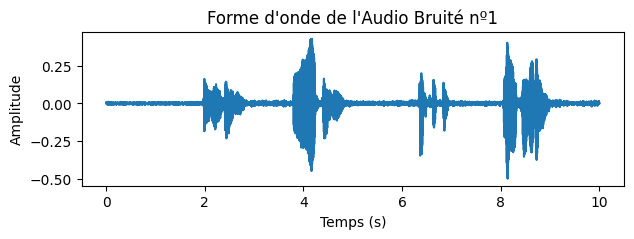

PESQ Score: 3.79
STOI Score: 0.99
---------------------------------------------

Audio original nº2:


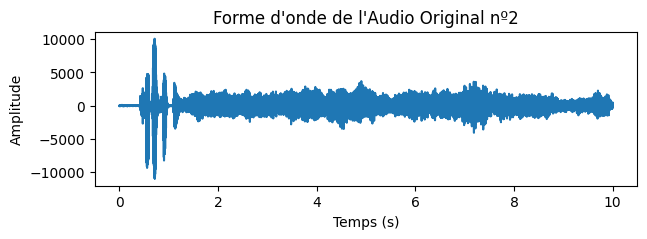

Audio bruité nº2:


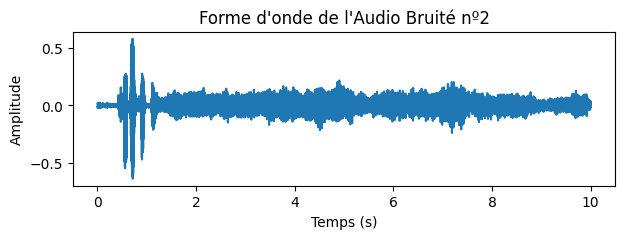

PESQ Score: 3.99
STOI Score: 0.95
---------------------------------------------

Audio original nº3:


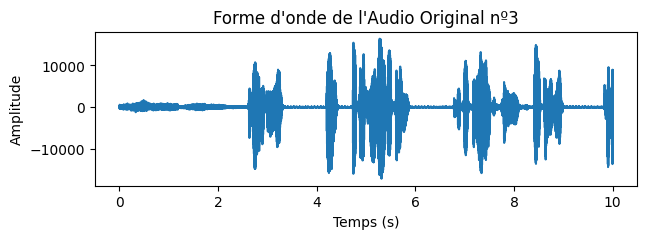

Audio bruité nº3:


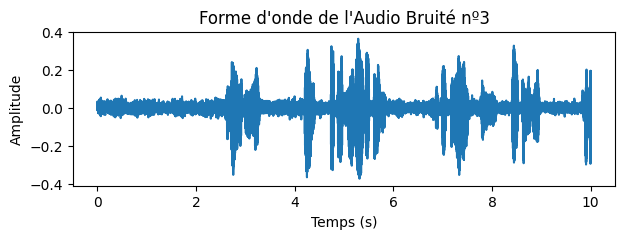

PESQ Score: 2.41
STOI Score: 0.76
---------------------------------------------

Audio original nº4:


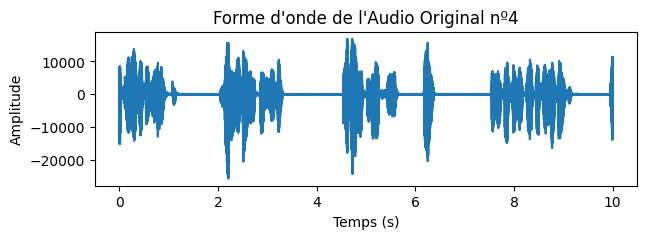

Audio bruité nº4:


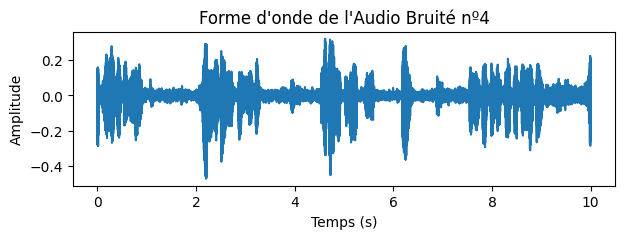

PESQ Score: 2.79
STOI Score: 0.95
---------------------------------------------

Audio original nº5:


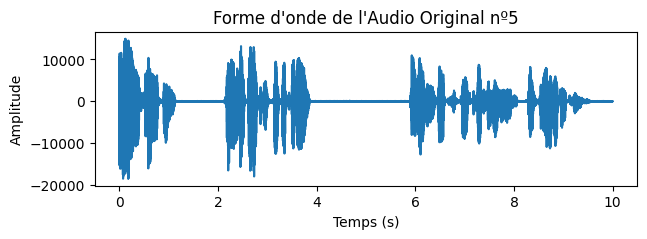

Audio bruité nº5:


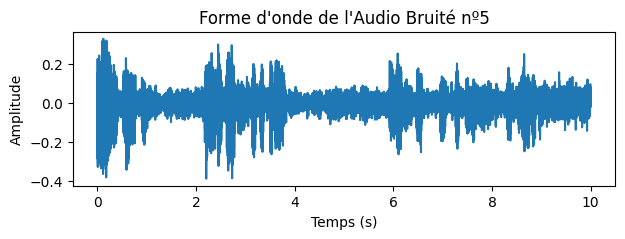

PESQ Score: 2.01
STOI Score: 0.88


In [ ]:
nbre_exemples = 5

for i in range(nbre_exemples):
    print("---------------------------------------------\n")
    print(f"Audio original nº{i+1}:")
    bruit, original, bruit_rate, original_rate, _, _ = trainsmall_dataset[i]

    # Affichage de la forme d'onde de l'audio original
    plt.figure(figsize=(7, 2))
    plt.plot(np.linspace(0, len(original) / original_rate, num=len(original)), original)
    plt.title(f"Forme d'onde de l'Audio Original nº{i+1}")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.show()

    print(f"Audio bruité nº{i+1}:")

    # Affichage de la forme d'onde de l'audio bruité
    plt.figure(figsize=(7, 2))
    plt.plot(np.linspace(0, len(bruit) / bruit_rate, num=len(bruit)), bruit)
    plt.title(f"Forme d'onde de l'Audio Bruité nº{i+1}")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.show()

    pesq_score = pesq(original_rate, original, bruit, 'nb')
    print(f"PESQ Score: {pesq_score:.2f}")

    stoi_score = stoi(original, bruit, original_rate)
    print(f"STOI Score: {stoi_score:.2f}")

Interprétation: Nous observons en effet que le SNR varie entre les différentes données fournies, à peu près comme l'on attendait. Cependant, on observe que le PESQ le plus petit correspond à l'audio nº5 alors que le STOI le plus petit correspond à l'audio nº3. L'explication est la suivante: tandis que le PESQ se concentre sur la qualité globale de la parole, le STOI cible spécifiquement l'intelligibilité. La différence entre le bruit de fond des deux audios explique ce fait.

## On vérifie que les fichiers audio ont un seul canal. Cela est essentiel pour implémenter TasNet.



In [ ]:
def check_wav_channels_scipy(filename):
    sample_rate, data = wavfile.read(filename)
    if len(data.shape) == 1:
        return 1  # Mono
    elif len(data.shape) == 2:
        return data.shape[1]

filename = "/content/drive/MyDrive/denoising_dlts/denoising/train_small/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav"
num_channels = check_wav_channels_scipy(filename)
if num_channels == 1:
    print("The file is mono.")
elif num_channels == 2:
    print("The file is stereo.")
else:
    print(f"The file has {num_channels} channels.")

The file is mono.


#TasNet: Time-domain audio separation network for real-time, single-channel speech separation

Dans ce premier modèle, on adapte le code de l'article [1] présent sur https://github.com/kaituoxu/TasNet .

[1] Y. Luo et Al., TaSNet: Time-Domain Audio Separation Network for Real-Time, Single-Channel Speech Separation, ICASSP 2018

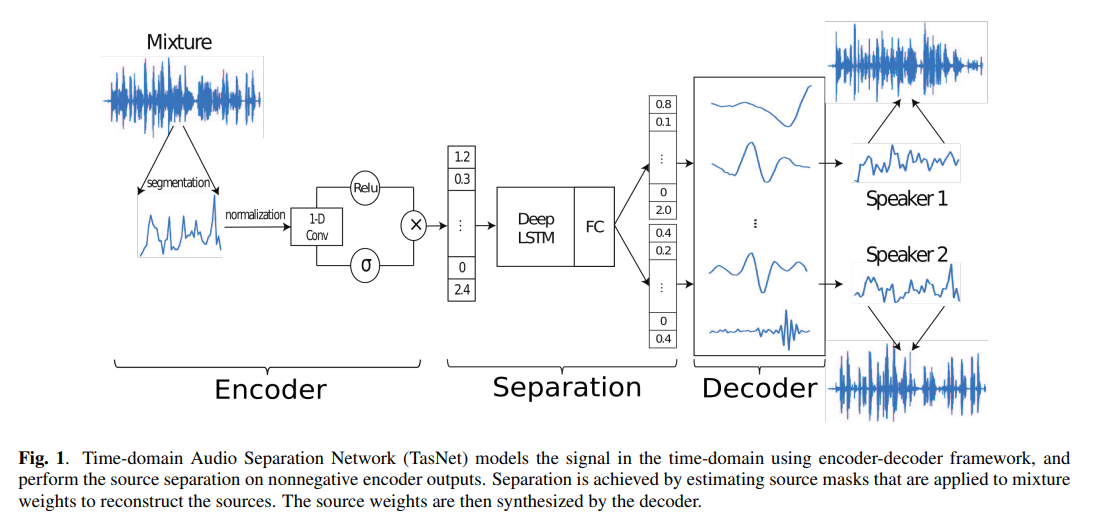

In [ ]:
# @title Architecture du modèle
from IPython.display import Image
Image(filename='/content/drive/MyDrive/denoising_dlts/model_architecture.png')

## Dataloader

Pour ce modèle, nous utilisons le dataset et le dataloader que nous avons défini dans la première partie du notebook.

## Loss

In [ ]:

EPS = 1e-8


def cal_loss(source, estimate_source, source_lengths):
    """
    Args:
        source: [B, C, K, L]
        estimate_source: [B, C, K, L]
        source_lengths: [B]
    """
    max_snr, perms, max_snr_idx = cal_si_snr_with_pit(source,
                                                      estimate_source,
                                                      source_lengths)
    loss = 0 - torch.mean(max_snr)
    reorder_estimate_source = reorder_source(estimate_source, perms, max_snr_idx)
    return loss, max_snr, estimate_source, reorder_estimate_source


def cal_si_snr_with_pit(source, estimate_source, source_lengths):
    """Calculate SI-SNR with PIT training.
    Args:
        source: [B, C, K, L]
        estimate_source: [B, C, K, L]
        source_lengths: [B], each item is between [0, K]
    """
    assert source.size() == estimate_source.size()
    B, C, K, L = source.size()
    # Step 1. Zero-mean norm
    num_samples = (L* source_lengths).view(-1, 1, 1, 1).float().cuda()  # [B, 1, 1, 1]
    mean_target = torch.sum(source, dim=[2, 3], keepdim=True) / num_samples
    mean_estimate = torch.sum(estimate_source, dim=[2, 3], keepdim=True) / num_samples
    zero_mean_target = source - mean_target
    zero_mean_estimate = estimate_source - mean_estimate
    # mask padding position along K
    mask = get_mask(source, source_lengths)
    zero_mean_target *= mask
    zero_mean_estimate *= mask

    # Step 2. SI-SNR with PIT
    # flat K, L to T (T = K * L)
    flat_target = zero_mean_target.view(B, C, -1)  # [B, C, T]
    flat_estimate = zero_mean_estimate.view(B, C, -1)  # [B, C, T]
    # reshape to use broadcast
    s_target = torch.unsqueeze(flat_target, dim=1)  # [B, 1, C, T]
    s_estimate = torch.unsqueeze(flat_estimate, dim=2)  # [B, C, 1, T]
    # s_target = <s', s>s / ||s||^2
    pair_wise_dot = torch.sum(s_estimate * s_target, dim=3, keepdim=True)  # [B, C, C, 1]
    s_target_energy = torch.sum(s_target ** 2, dim=3, keepdim=True) + EPS  # [B, 1, C, 1]
    pair_wise_proj = pair_wise_dot * s_target / s_target_energy  # [B, C, C, T]
    # e_noise = s' - s_target
    e_noise = s_estimate - pair_wise_proj  # [B, C, C, T]
    # SI-SNR = 10 * log_10(||s_target||^2 / ||e_noise||^2)
    pair_wise_si_snr = torch.sum(pair_wise_proj ** 2, dim=3) / (torch.sum(e_noise ** 2, dim=3) + EPS)
    pair_wise_si_snr = 10 * torch.log10(pair_wise_si_snr + EPS)  # [B, C, C]

    # Get max_snr of each utterance
    # permutations, [C!, C]
    perms = source.new_tensor(list(permutations(range(C))), dtype=torch.long)
    # one-hot, [C!, C, C]
    index = torch.unsqueeze(perms, 2)
    perms_one_hot = source.new_zeros((*perms.size(), C)).scatter_(2, index, 1)
    # [B, C!] <- [B, C, C] einsum [C!, C, C], SI-SNR sum of each permutation
    snr_set = torch.einsum('bij,pij->bp', [pair_wise_si_snr, perms_one_hot])
    max_snr_idx = torch.argmax(snr_set, dim=1)  # [B]
    # max_snr = torch.gather(snr_set, 1, max_snr_idx.view(-1, 1))  # [B, 1]
    max_snr, _ = torch.max(snr_set, dim=1, keepdim=True)
    max_snr /= C
    return max_snr, perms, max_snr_idx


def reorder_source(source, perms, max_snr_idx):
    """
    Args:
        source: [B, C, K, L]
        perms: [C!, C], permutations
        max_snr_idx: [B], each item is between [0, C!)
    Returns:
        reorder_source: [B, C, K, L]
    """
    B, C, *_ = source.size()
    # [B, C], permutation whose SI-SNR is max of each utterance
    # for each utterance, reorder estimate source according this permutation
    max_snr_perm = torch.index_select(perms, dim=0, index=max_snr_idx)
    reorder_source = torch.zeros_like(source)
    for b in range(B):
        for c in range(C):
            reorder_source[b, c] = source[b, max_snr_perm[b][c]]
    return reorder_source


def get_mask(source, source_lengths):
    B, _, K, _ = source.size()
    mask = source.new_ones((B, 1, K, 1))
    for i in range(B):
        mask[i, :, source_lengths[i]:, :] = 0
    return mask

## Modèle

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

EPS = 1e-8


class TasNet(nn.Module):
    def __init__(self, L, N, hidden_size, num_layers,
                 bidirectional=True, nspk=2):
        super(TasNet, self).__init__()
        # hyper-parameter
        self.L, self.N = L, N
        self.hidden_size, self.num_layers = hidden_size, num_layers
        self.bidirectional = bidirectional
        self.nspk = nspk
        # Components
        self.encoder = Encoder(L, N)
        self.separator = Separator(N, hidden_size, num_layers,
                                   bidirectional=bidirectional, nspk=nspk)
        self.decoder = Decoder(N, L)

    def forward(self, mixture, mixture_lengths):
        """
        Args:
            mixture: [B, K, L]
            mixture_lengths: [B]
        Returns:
            est_source: [B, nspk, K, L]
        """
        mixture_w, norm_coef = self.encoder(mixture)
        est_mask = self.separator(mixture_w, mixture_lengths)
        est_source = self.decoder(mixture_w, est_mask, norm_coef)
        return est_source

    @classmethod
    def load_model(cls, path):
        # Load to CPU
        package = torch.load(path, map_location=lambda storage, loc: storage)
        model = cls.load_model_from_package(package)
        return model

    @classmethod
    def load_model_from_package(cls, package):
        model = cls(package['L'], package['N'],
                    package['hidden_size'], package['num_layers'],
                    bidirectional=package['bidirectional'],
                    nspk=package['nspk'])
        model.load_state_dict(package['state_dict'])
        return model

    @staticmethod
    def serialize(model, optimizer, epoch, tr_loss=None, cv_loss=None):
        package = {
            # hyper-parameter
            'L': model.L,
            'N': model.N,
            'hidden_size': model.hidden_size,
            'num_layers': model.num_layers,
            'bidirectional': model.bidirectional,
            'nspk': model.nspk,
            # state
            'state_dict': model.state_dict(),
            'optim_dict': optimizer.state_dict(),
            'epoch': epoch
        }
        if tr_loss is not None:
            package['tr_loss'] = tr_loss
            package['cv_loss'] = cv_loss
        return package


class Encoder(nn.Module):
    """Estimation of the nonnegative mixture weight by a 1-D gated conv layer.
    """
    def __init__(self, L, N):
        super(Encoder, self).__init__()
        # hyper-parameter
        self.L = L
        self.N = N
        # Components
        self.conv1d_U = nn.Conv1d(L, N, kernel_size=1, stride=1, bias=False)
        self.conv1d_V = nn.Conv1d(L, N, kernel_size=1, stride=1, bias=False)

    def forward(self, mixture):
        """
        Args:
            mixture: [B, K, L]
        Returns:
            mixture_w: [B, K, N]
            norm_coef: [B, K, 1]
        """
        B, K, L = mixture.size()
        # L2 Norm along L axis
        norm_coef = torch.norm(mixture, p=2, dim=2, keepdim=True)  # B x K x 1
        norm_mixture = mixture / (norm_coef + EPS) # B x K x L
        # 1-D gated conv
        norm_mixture = torch.unsqueeze(norm_mixture.view(-1, L), 2)  # B*K x L x 1
        conv = F.relu(self.conv1d_U(norm_mixture))         # B*K x N x 1
        gate = torch.sigmoid(self.conv1d_V(norm_mixture))  # B*K x N x 1
        mixture_w = conv * gate  # B*K x N x 1
        mixture_w = mixture_w.view(B, K, self.N) # B x K x N
        return mixture_w, norm_coef


class Separator(nn.Module):
    """Estimation of source masks
    TODO: 1. normlization described in paper
          2. LSTM with skip connection
    """
    def __init__(self, N, hidden_size, num_layers, bidirectional=True, nspk=2):
        super(Separator, self).__init__()
        # hyper-parameter
        self.N = N
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.nspk = nspk
        # Components
        self.layer_norm = nn.LayerNorm(N)
        self.rnn = nn.LSTM(N, hidden_size, num_layers,
                           batch_first=True,
                           bidirectional=bidirectional)
        fc_in_dim = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(fc_in_dim, nspk * N)

    def forward(self, mixture_w, mixture_lengths):
        """
        Args:
            mixture_w: [B, K, N], padded
        Returns:
            est_mask: [B, K, nspk, N]
        """
        B, K, N = mixture_w.size()
        # layer norm
        norm_mixture_w = self.layer_norm(mixture_w)
        # LSTM
        total_length = norm_mixture_w.size(1)  # get the max sequence length
        packed_input = pack_padded_sequence(norm_mixture_w, mixture_lengths,
                                            batch_first=True)
        packed_output, hidden = self.rnn(packed_input)
        output, _ = pad_packed_sequence(packed_output,
                                        batch_first=True,
                                        total_length=total_length)
        # fc
        score = self.fc(output)  # B x K x nspk*N
        score = score.view(B, K, self.nspk, N)
        # softmax
        est_mask = F.softmax(score, dim=2)
        return est_mask


class Decoder(nn.Module):
    def __init__(self, N, L):
        super(Decoder, self).__init__()
        # hyper-parameter
        self.N, self.L = N, L
        # Components
        self.basis_signals = nn.Linear(N, L, bias=False)

    def forward(self, mixture_w, est_mask, norm_coef):
        """
        Args:
            mixture_w: [B, K, N]
            est_mask: [B, K, nspk, N]
            norm_coef: [B, K, 1]
        Returns:
            est_source: [B, nspk, K, L]
        """
        # D = W * M
        source_w = torch.unsqueeze(mixture_w, 2) * est_mask  # B x K x nspk x N
        # S = DB
        est_source = self.basis_signals(source_w)  # B x K x nspk x L
        # reverse L2 norm
        norm_coef = torch.unsqueeze(norm_coef, 2)  # B x K x 1 x1
        est_source = est_source * norm_coef  # B x K x nspk x L
        est_source = est_source.permute((0, 2, 1, 3)).contiguous() # B x nspk x K x L
        return est_source

## Entrainement

Ici, nous avons interrompu l'entrainement après 7 epochs puisque ça prenait beaucoup de temps. Nous avons décidé de le laisser comme ça puisque nous obtenons des résultats très satisfaisants.

In [ ]:
L, N = 40, 500
hidden_size, num_layers = 500, 4
model = TasNet(L, N, hidden_size, num_layers)
model = model.cuda()
optim = torch.optim.Adam(model.parameters(), lr = 0.001) #Adam optimizer
number_epoch=40

In [ ]:
path_to_save = '/content/drive/MyDrive/denoising_dlts/checkpoints2'
os.makedirs(path_to_save, exist_ok=True)

best_val_loss = float('inf')  # Initialisation de la meilleure loss

for epoch in range(number_epoch):
    model.train()

    train_loss = 0
    val_loss = 0

    for i, (padded_mixture, mixture_lengths, padded_source) in enumerate(train_dataloader):
            padded_mixture = padded_mixture.cuda()
            #mixture_lengths = mixture_lengths.cuda()
            padded_source = padded_source.cuda()

            estimate_source = model(padded_mixture, mixture_lengths)

            loss, max_snr, estimate_source, reorder_estimate_source = cal_loss(padded_source, estimate_source, mixture_lengths)

            optim.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optim.step()

            train_loss += loss.item()

            # Clear memory
            del loss, estimate_source, reorder_estimate_source
            torch.cuda.empty_cache()
            gc.collect()

    train_loss = train_loss / (i + 1)

    model.eval()

    for i, (padded_mixture, mixture_lengths, padded_source) in enumerate(test_dataloader):
            padded_mixture = padded_mixture.cuda()
            #mixture_lengths = mixture_lengths.cuda()
            padded_source = padded_source.cuda()

            estimate_source = model(padded_mixture, mixture_lengths)

            loss, max_snr, estimate_source, reorder_estimate_source = cal_loss(padded_source, estimate_source, mixture_lengths)

            val_loss += loss.item()

            # Clear memory
            del loss, estimate_source, reorder_estimate_source
            torch.cuda.empty_cache()
            gc.collect()

    val_loss = val_loss / (i + 1)

    # Print the epoch loss and the accuracies
    print(f"Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    # Save the current state of the model.
    torch.save(model.state_dict(), os.path.join(path_to_save, f'checkpoint_epoch_{epoch}.pt'))

    # Check if this is the best accuracy so far and save if it is
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(path_to_save, 'best_accuracy_checkpoint.pt'))

Epoch 0, Train Loss: -7.882060826105891, Validation Loss: -11.590518504758425
Epoch 1, Train Loss: -12.780347842090535, Validation Loss: -14.168708632263955
Epoch 2, Train Loss: -14.325443506240845, Validation Loss: -14.939642797542524
Epoch 3, Train Loss: -14.942426393616874, Validation Loss: -15.269920035253596
Epoch 4, Train Loss: -15.296399984719619, Validation Loss: -15.62406454207022
Epoch 5, Train Loss: -15.531639953829208, Validation Loss: -15.829237587844268
Epoch 6, Train Loss: -15.513852812209219, Validation Loss: -15.885396160656892


KeyboardInterrupt: ignored

#Conv-tasnet: surpassing ideal time–frequency magnitude masking for speech separation
Dans ce deuxième modèle, on adapte le code de l'article [2] présent sur  https://github.com/JusperLee/Conv-TasNet .

Conv-TasNet est généralement plus efficace en termes de calcul par rapport à TasNet en raison de l'absence de RNNs (réseaux de neurones récurrents). Il a été démontré qu'il surpasse TasNet dans de nombreux scénarios, notamment en termes de vitesse et de qualité de séparation.

Pourquoi n'avons-nous pas implémenté Wave-U-Net ? Bien que les trois soient utilisés pour la séparation de sources, la conception spécifique de Wave-U-Net le rend particulièrement adapté à la séparation de sources musicales, où la capture des relations entre différentes fréquences est cruciale.

[2] Y. Luo et Al., Conv-tasnet: surpassing ideal time–frequency magnitude masking for speech separation. IEEE/ACM Transactions on Audio, Speech, and Language Processing, 2019.

## Dataloader

In [ ]:
class ConvTasNetDataset(Dataset):
    def __init__(self, noise_folder_path, original_folder_path):
        self.noise_files = [os.path.join(noise_folder_path, f) for f in os.listdir(noise_folder_path) if f.endswith('.wav')]
        self.original_files = [os.path.join(original_folder_path, f) for f in os.listdir(original_folder_path) if f.endswith('.wav')]

        # On les met dans l'ordre croissant de chiffres (Partie, Chapitre, Numéro) pour s'assurer qu'il y ait une correspondance entre les
        # originaux et les bruités (en important les données sur Drive, l'ordre a changé):

        def extraire_numeros(fichier):
            # Diviser le nom du fichier en parties
            parties = fichier.split('_')
            # Trouver l'index de l'élément qui commence par "Partie"
            index_partie = next(i for i, part in enumerate(parties) if part.startswith("Partie"))
            # Trouver l'index de l'élément qui commence par "Chap"
            index_chap = next(i for i, part in enumerate(parties) if part.startswith("Chap"))
            # Extraire le numéro de partie, de chapitre et de fichier
            num_partie = int(parties[index_partie][6:])  # Extrait le numéro après "Partie"
            num_chapitre = int(parties[index_chap][4:])  # Extrait le numéro après "Chap"
            num_fichier = int(parties[-2])  # Extrait le numéro à la fin
            return (num_partie, num_chapitre, num_fichier)

        # Trier les fichiers en fonction du numéro extrait
        self.noise_files = sorted(self.noise_files, key=extraire_numeros)
        self.original_files = sorted(self.original_files, key=extraire_numeros)


    def __len__(self):
        return len(self.noise_files) # Les fichiers noisy et originaux ont la même longueur

    def __getitem__(self, idx):
        noise_path = self.noise_files[idx]
        original_path = self.original_files[idx]

        #noise_rate, noise_data = wavfile.read(noise_path)
        #original_rate, original_data = wavfile.read(original_path)

        noise_data, noise_rate = torchaudio.load(noise_path, channels_first=True)
        original_data, original_rate = torchaudio.load(original_path, channels_first=True)

        mix = noise_data.squeeze()
        ref = [original_data.squeeze(), (noise_data - original_data).squeeze()]
        return {
            'mix': mix,
            'ref': ref
        }

class Spliter():
    '''
       Split the audio. All audio is divided
       into 4s according to the requirements in the paper.
       input:
             chunk_size: split size
             least: Less than this value will not be read
    '''

    def __init__(self, chunk_size=32000, is_train=True, least=16000):
        super(Spliter, self).__init__()
        self.chunk_size = chunk_size
        self.is_train = is_train
        self.least = least

    def chunk_audio(self, sample, start):
        '''
           Make a chunk audio
           sample: a audio sample
           start: split start time
        '''
        chunk = dict()
        chunk['mix'] = sample['mix'][start:start+self.chunk_size]
        chunk['ref'] = [r[start:start+self.chunk_size] for r in sample['ref']]
        return chunk

    def splits(self, sample):
        '''
           Split a audio sample
        '''
        length = sample['mix'].shape[0]
        if length < self.least:
            return []
        audio_lists = []
        if length < self.chunk_size:
            gap = self.chunk_size-length
            sample['mix'] = F.pad(sample['mix'], (0, gap), mode='constant')
            sample['ref'] = [F.pad(r, (0, gap), mode='constant')
                             for r in sample['ref']]
            audio_lists.append(sample)
        else:
            random_start = random.randint(
                0, length % self.least) if self.is_train else 0
            while True:
                if random_start+self.chunk_size > length:
                    break
                audio_lists.append(self.chunk_audio(sample, random_start))
                random_start += self.least
        return audio_lists


class DataLoaders():
    '''
        Custom dataloader method
        input:
              dataset (Dataset): dataset from which to load the data.
              num_workers (int, optional): how many subprocesses to use for data (default: 4)
              chunk_size (int, optional): split audio size (default: 32000(4 s))
              batch_size (int, optional): how many samples per batch to load
              is_train: if this dataloader for training
    '''

    def __init__(self, dataset, num_workers=4, chunk_size=32000, batch_size=1, is_train=True):
        super(DataLoaders, self).__init__()
        self.dataset = dataset
        self.num_workers = num_workers
        self.chunk_size = chunk_size
        self.batch_size = batch_size
        self.is_train = is_train
        self.data_loader = DataLoader(self.dataset,
                                      num_workers=self.num_workers,
                                      batch_size=self.batch_size // 2,
                                      shuffle=self.is_train,
                                      collate_fn=self._collate)
        self.spliter = Spliter(
            chunk_size=self.chunk_size, is_train=self.is_train, least=self.chunk_size // 2)

    def _collate(self, batch):
        '''
            merges a list of samples to form a
            mini-batch of Tensor(s).  Used when using batched loading from a
            map-style dataset.
        '''
        batch_audio = []
        for b in batch:
            batch_audio += self.spliter.splits(b)
        return batch_audio

    def __iter__(self):
        mini_batch = []
        for batch in self.data_loader:
            mini_batch += batch
            length = len(mini_batch)
            if self.is_train:
                random.shuffle(mini_batch)
            collate_chunk = []
            for start in range(0, length-self.batch_size+1, self.batch_size):
                b = default_collate(
                    mini_batch[start:start+self.batch_size])
                collate_chunk.append(b)
            idx = length % self.batch_size
            mini_batch = mini_batch[-idx:] if idx else []
            for m_batch in collate_chunk:
                yield m_batch # batch of datasets
                '''
                   mini_batch like this
                   'mix': batch x L
                   'ref': [bathc x L, bathc x L]
                '''

In [ ]:
#Train_small
trainsmall_dataset = ConvTasNetDataset(noise_trainsmall_path, original_trainsmall_path)
train_dataset = ConvTasNetDataset(noise_train_path, original_train_path)
test_dataset = ConvTasNetDataset(noise_test_path, original_test_path)

# On crée un dataloader pour chaque ensemble de données:
num_workers = 4
batch_size = 32

trainsmall_dataloader = DataLoaders(trainsmall_dataset, batch_size=batch_size, num_workers=num_workers, is_train=True)
train_dataloader = DataLoaders(train_dataset, batch_size=batch_size, num_workers=num_workers, is_train=True)
test_dataloader = DataLoaders(test_dataset, batch_size=batch_size, num_workers=num_workers, is_train=False)
test_dataloader_conv = test_dataloader

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Modèle

In [ ]:
class GlobalLayerNorm(nn.Module):
    '''
       Calculate Global Layer Normalization
       dim: (int or list or torch.Size) –
            input shape from an expected input of size
       eps: a value added to the denominator for numerical stability.
       elementwise_affine: a boolean value that when set to True,
           this module has learnable per-element affine parameters
           initialized to ones (for weights) and zeros (for biases).
    '''

    def __init__(self, dim, eps=1e-05, elementwise_affine=True):
        super(GlobalLayerNorm, self).__init__()
        self.dim = dim
        self.eps = eps
        self.elementwise_affine = elementwise_affine

        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(self.dim, 1))
            self.bias = nn.Parameter(torch.zeros(self.dim, 1))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)

    def forward(self, x):
        # x = N x C x L
        # N x 1 x 1
        # cln: mean,var N x 1 x L
        # gln: mean,var N x 1 x 1
        if x.dim() != 3:
            raise RuntimeError("{} accept 3D tensor as input".format(
                self.__name__))

        mean = torch.mean(x, (1, 2), keepdim=True)
        var = torch.mean((x-mean)**2, (1, 2), keepdim=True)
        # N x C x L
        if self.elementwise_affine:
            x = self.weight*(x-mean)/torch.sqrt(var+self.eps)+self.bias
        else:
            x = (x-mean)/torch.sqrt(var+self.eps)
        return x


class CumulativeLayerNorm(nn.LayerNorm):
    '''
       Calculate Cumulative Layer Normalization
       dim: you want to norm dim
       elementwise_affine: learnable per-element affine parameters
    '''

    def __init__(self, dim, elementwise_affine=True):
        super(CumulativeLayerNorm, self).__init__(
            dim, elementwise_affine=elementwise_affine)

    def forward(self, x):
        # x: N x C x L
        # N x L x C
        x = torch.transpose(x, 1, 2)
        # N x L x C == only channel norm
        x = super().forward(x)
        # N x C x L
        x = torch.transpose(x, 1, 2)
        return x


def select_norm(norm, dim):
    if norm not in ['gln', 'cln', 'bn']:
        if x.dim() != 3:
            raise RuntimeError("{} accept 3D tensor as input".format(
                self.__name__))

    if norm == 'gln':
        return GlobalLayerNorm(dim, elementwise_affine=True)
    if norm == 'cln':
        return CumulativeLayerNorm(dim, elementwise_affine=True)
    else:
        return nn.BatchNorm1d(dim)


class Conv1D(nn.Conv1d):
    '''
       Applies a 1D convolution over an input signal composed of several input planes.
    '''

    def __init__(self, *args, **kwargs):
        super(Conv1D, self).__init__(*args, **kwargs)

    def forward(self, x, squeeze=False):
        # x: N x C x L
        if x.dim() not in [2, 3]:
            raise RuntimeError("{} accept 2/3D tensor as input".format(
                self.__name__))
        x = super().forward(x if x.dim() == 3 else torch.unsqueeze(x, 1))
        if squeeze:
            x = torch.squeeze(x)
        return x


class ConvTrans1D(nn.ConvTranspose1d):
    '''
       This module can be seen as the gradient of Conv1d with respect to its input.
       It is also known as a fractionally-strided convolution
       or a deconvolution (although it is not an actual deconvolution operation).
    '''

    def __init__(self, *args, **kwargs):
        super(ConvTrans1D, self).__init__(*args, **kwargs)

    def forward(self, x, squeeze=False):
        """
        x: N x L or N x C x L
        """
        if x.dim() not in [2, 3]:
            raise RuntimeError("{} accept 2/3D tensor as input".format(
                self.__name__))
        x = super().forward(x if x.dim() == 3 else torch.unsqueeze(x, 1))
        if squeeze:
            x = torch.squeeze(x)
        return x


class Conv1D_Block(nn.Module):
    '''
       Consider only residual links
    '''

    def __init__(self, in_channels=256, out_channels=512,
                 kernel_size=3, dilation=1, norm='gln', causal=False):
        super(Conv1D_Block, self).__init__()
        # conv 1 x 1
        self.conv1x1 = Conv1D(in_channels, out_channels, 1)
        self.PReLU_1 = nn.PReLU()
        self.norm_1 = select_norm(norm, out_channels)
        # not causal don't need to padding, causal need to pad+1 = kernel_size
        self.pad = (dilation * (kernel_size - 1)) // 2 if not causal else (
            dilation * (kernel_size - 1))
        # depthwise convolution
        self.dwconv = Conv1D(out_channels, out_channels, kernel_size,
                             groups=out_channels, padding=self.pad, dilation=dilation)
        self.PReLU_2 = nn.PReLU()
        self.norm_2 = select_norm(norm, out_channels)
        self.Sc_conv = nn.Conv1d(out_channels, in_channels, 1, bias=True)
        self.causal = causal

    def forward(self, x):
        # x: N x C x L
        # N x O_C x L
        c = self.conv1x1(x)
        # N x O_C x L
        c = self.PReLU_1(c)
        c = self.norm_1(c)
        # causal: N x O_C x (L+pad)
        # noncausal: N x O_C x L
        c = self.dwconv(c)
        # N x O_C x L
        if self.causal:
            c = c[:, :, :-self.pad]
        c = self.Sc_conv(c)
        return x+c


class ConvTasNet(nn.Module):
    '''
       ConvTasNet module
       N	Number of ﬁlters in autoencoder
       L	Length of the ﬁlters (in samples)
       B	Number of channels in bottleneck and the residual paths’ 1 × 1-conv blocks
       Sc	Number of channels in skip-connection paths’ 1 × 1-conv blocks
       H	Number of channels in convolutional blocks
       P	Kernel size in convolutional blocks
       X	Number of convolutional blocks in each repeat
       R	Number of repeats
    '''

    def __init__(self,
                 N=512,
                 L=16,
                 B=128,
                 H=512,
                 P=3,
                 X=8,
                 R=3,
                 norm="gln",
                 num_spks=2,
                 activate="relu",
                 causal=False):
        super(ConvTasNet, self).__init__()
        # n x 1 x T => n x N x T
        self.encoder = Conv1D(1, N, L, stride=L // 2, padding=0)
        # n x N x T  Layer Normalization of Separation
        self.LayerN_S = select_norm('cln', N)
        # n x B x T  Conv 1 x 1 of  Separation
        self.BottleN_S = Conv1D(N, B, 1)
        # Separation block
        # n x B x T => n x B x T
        self.separation = self._Sequential_repeat(
            R, X, in_channels=B, out_channels=H, kernel_size=P, norm=norm, causal=causal)
        # n x B x T => n x 2*N x T
        self.gen_masks = Conv1D(B, num_spks*N, 1)
        # n x N x T => n x 1 x L
        self.decoder = ConvTrans1D(N, 1, L, stride=L//2)
        # activation function
        active_f = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'softmax': nn.Softmax(dim=0)
        }
        self.activation_type = activate
        self.activation = active_f[activate]
        self.num_spks = num_spks

    def _Sequential_block(self, num_blocks, **block_kwargs):
        '''
           Sequential 1-D Conv Block
           input:
                 num_block: how many blocks in every repeats
                 **block_kwargs: parameters of Conv1D_Block
        '''
        Conv1D_Block_lists = [Conv1D_Block(
            **block_kwargs, dilation=(2**i)) for i in range(num_blocks)]

        return nn.Sequential(*Conv1D_Block_lists)

    def _Sequential_repeat(self, num_repeats, num_blocks, **block_kwargs):
        '''
           Sequential repeats
           input:
                 num_repeats: Number of repeats
                 num_blocks: Number of block in every repeats
                 **block_kwargs: parameters of Conv1D_Block
        '''
        repeats_lists = [self._Sequential_block(
            num_blocks, **block_kwargs) for i in range(num_repeats)]
        return nn.Sequential(*repeats_lists)

    def forward(self, x):
        if x.dim() >= 3:
            raise RuntimeError(
                "{} accept 1/2D tensor as input, but got {:d}".format(
                    self.__name__, x.dim()))
        if x.dim() == 1:
            x = torch.unsqueeze(x, 0)
        # x: n x 1 x L => n x N x T
        w = self.encoder(x)
        # n x N x L => n x B x L
        e = self.LayerN_S(w)
        e = self.BottleN_S(e)
        # n x B x L => n x B x L
        e = self.separation(e)
        # n x B x L => n x num_spk*N x L
        m = self.gen_masks(e)
        # n x N x L x num_spks
        m = torch.chunk(m, chunks=self.num_spks, dim=1)
        # num_spks x n x N x L
        m = self.activation(torch.stack(m, dim=0))
        d = [w*m[i] for i in range(self.num_spks)]
        # decoder part num_spks x n x L
        s = [self.decoder(d[i], squeeze=True) for i in range(self.num_spks)]
        return s

## Loss

In [ ]:
def SI_SNR(_s, s, zero_mean=True):
    '''
         Calculate the SNR indicator between the two audios.
         The larger the value, the better the separation.
         input:
               _s: Generated audio
               s:  Ground Truth audio
         output:
               SNR value
    '''
    if zero_mean:
        _s = _s - torch.mean(_s)
        s = s - torch.mean(s)
    s_target = sum(torch.mul(_s, s))*s/torch.pow(torch.norm(s, p=2), 2)
    e_noise = _s - s_target
    return 20*torch.log10(torch.norm(s_target, p=2)/torch.norm(e_noise, p=2))


def permute_SI_SNR(_s_lists, s_lists):
    '''
        Calculate all possible SNRs according to
        the permutation combination and
        then find the maximum value.
        input:
               _s_lists: Generated audio list
               s_lists: Ground truth audio list
        output:
               max of SI-SNR
    '''
    length = len(_s_lists)
    results = []
    for p in permutations(range(length)):
        s_list = [s_lists[n] for n in p]
        result = sum([SI_SNR(_s, s) for _s, s in zip(_s_lists, s_list)])/length
        results.append(result)
    return max(results)


def sisnr(x, s, eps=1e-8):
    """
    calculate training loss
    input:
          x: separated signal, N x S tensor
          s: reference signal, N x S tensor
    Return:
          sisnr: N tensor
    """

    def l2norm(mat, keepdim=False):
        return torch.norm(mat, dim=-1, keepdim=keepdim)

    if x.shape != s.shape:
        raise RuntimeError(
            "Dimention mismatch when calculate si-snr, {} vs {}".format(
                x.shape, s.shape))
    x_zm = x - torch.mean(x, dim=-1, keepdim=True)
    s_zm = s - torch.mean(s, dim=-1, keepdim=True)
    t = torch.sum(
        x_zm * s_zm, dim=-1,
        keepdim=True) * s_zm / (l2norm(s_zm, keepdim=True)**2 + eps)
    return 20 * torch.log10(eps + l2norm(t) / (l2norm(x_zm - t) + eps))


def si_snr_loss(ests, egs):
    # spks x n x S
    refs = egs["ref"]
    num_spks = len(refs)

    def sisnr_loss(permute):
        # for one permute
        return sum(
            [sisnr(ests[s], refs[t])
             for s, t in enumerate(permute)]) / len(permute)
        # average the value

    # P x N
    N = egs["mix"].size(0)
    sisnr_mat = torch.stack(
        [sisnr_loss(p) for p in permutations(range(num_spks))])
    max_perutt, _ = torch.max(sisnr_mat, dim=0)
    # si-snr
    return -torch.sum(max_perutt) / N

## Entrainement

In [ ]:
model = ConvTasNet(X=4, R=2, H=128, B=32)
model = model.cuda()
optim = torch.optim.Adam(model.parameters(), lr = 0.001) #Adam optimizer
number_epoch=40 # 40 epochs

In [ ]:
# Define the path where checkpoints will be saved.
path_to_save = '/content/drive/MyDrive/denoising_dlts/checkpoints_conv'
os.makedirs(path_to_save, exist_ok=True)

best_val_loss = float('inf')  # Initialize the best loss

for epoch in range(number_epoch):
    model.train()

    train_loss = 0
    val_loss = 0

    for i, egs in enumerate(train_dataloader):

            egs['mix'] = egs['mix'].cuda()
            egs['ref'][0] = egs['ref'][0].cuda()
            egs['ref'][1] = egs['ref'][1].cuda()
            #padded_mixture = padded_mixture.cuda()
            #mixture_lengths = mixture_lengths.cuda()
            #padded_source = padded_source.cuda()

            estimate_source = model(egs['mix'])

            loss = si_snr_loss(estimate_source, egs)

            optim.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optim.step()

            train_loss += loss.item()

            # Clear memory
            del loss, estimate_source
            torch.cuda.empty_cache()
            gc.collect()

    train_loss = train_loss / (i + 1)

    model.eval()

    for i, egs in enumerate(test_dataloader):

            egs['mix'] = egs['mix'].cuda()
            egs['ref'][0] = egs['ref'][0].cuda()
            egs['ref'][1] = egs['ref'][1].cuda()

            estimate_source = model(egs['mix'])

            loss = si_snr_loss(estimate_source, egs)

            val_loss += loss.item()

            # Clear memory
            del loss, estimate_source
            torch.cuda.empty_cache()
            gc.collect()

    val_loss = val_loss / (i + 1)

    # Print the epoch loss and the accuracies
    print(f"Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    # Save the current state of the model.
    torch.save(model.state_dict(), os.path.join(path_to_save, f'checkpoint_epoch_{epoch}.pt'))

    # Check if this is the best accuracy so far and save if it is
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(path_to_save, 'best_accuracy_checkpoint.pt'))

Epoch 0, Train Loss: -5.7988983186131176, Validation Loss: -8.596649804066137
Epoch 1, Train Loss: -8.173549832719745, Validation Loss: -9.223205792535211
Epoch 2, Train Loss: -8.591789538210088, Validation Loss: -9.336331205269724
Epoch 3, Train Loss: -9.000641457962267, Validation Loss: -9.886033869281258
Epoch 4, Train Loss: -9.222279102513284, Validation Loss: -10.105763219066501
Epoch 5, Train Loss: -9.508821028651614, Validation Loss: -10.346518840986429
Epoch 6, Train Loss: -9.724214418367906, Validation Loss: -10.587047252458396
Epoch 7, Train Loss: -9.872794180205375, Validation Loss: -10.280979102419824
Epoch 8, Train Loss: -9.952012997685056, Validation Loss: -10.7568669859896
Epoch 9, Train Loss: -10.179814936536731, Validation Loss: -10.896696115277477
Epoch 10, Train Loss: -10.235788488026822, Validation Loss: -10.855930387359304
Epoch 11, Train Loss: -10.328529778755072, Validation Loss: -11.284837693283238
Epoch 12, Train Loss: -10.533250295754636, Validation Loss: -10.

# Test

Dans cette partie, nous allons tester les deux modèles que nous avons implémenté. Pour chacun des modèles, nous réaliserons de l'inférence sur 3 échantillons de l'ensemble test et nous nous intéresserons à l'écoute du triplet audio original - audio bruité - audio débruité, à leur forme d'onde puis aux métriques PESQ et STOI qui seront calculées entre les audios originaux et les débruités.


## Test - TasNet

Audio bruité nº 1:


Audio original nº 1:


Audio débruité par TasNet nº1:


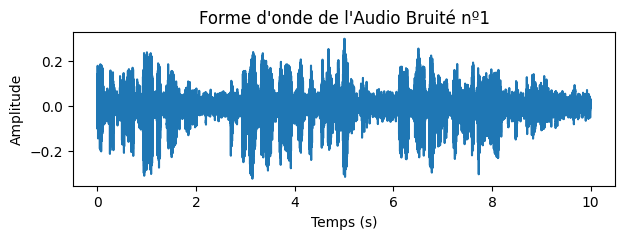

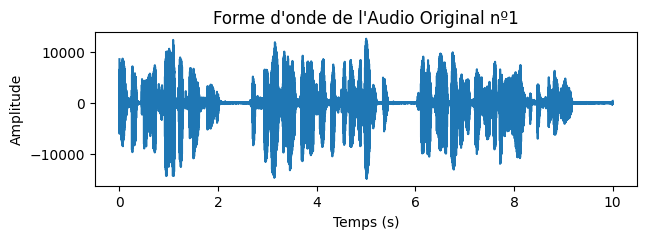

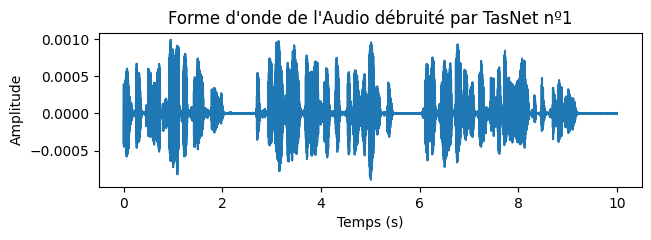

PESQ Score: 2.42
STOI Score: 0.91
---------------------------------------------




Audio bruité nº 2:


Audio original nº 2:


Audio débruité par TasNet nº2:


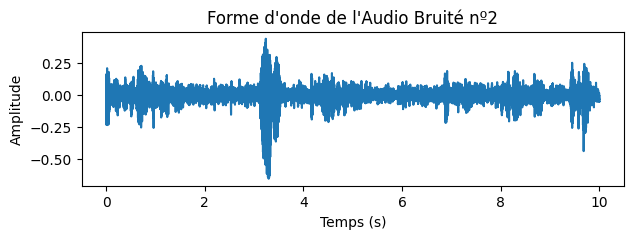

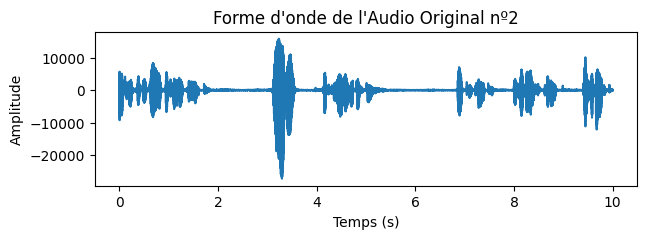

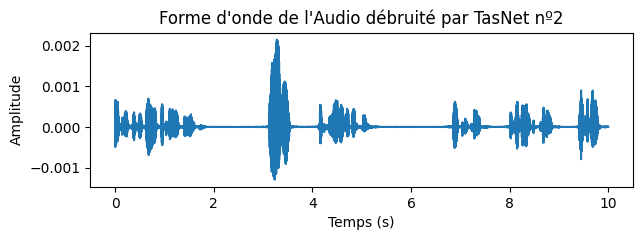

PESQ Score: 2.78
STOI Score: 0.91
---------------------------------------------




Audio bruité nº 3:


Audio original nº 3:


Audio débruité par TasNet nº3:


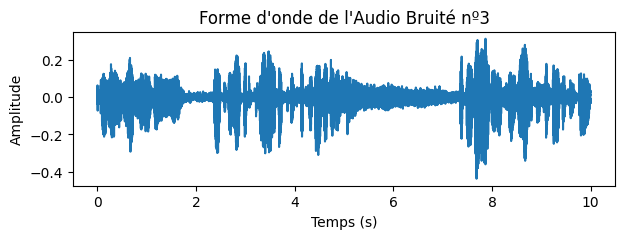

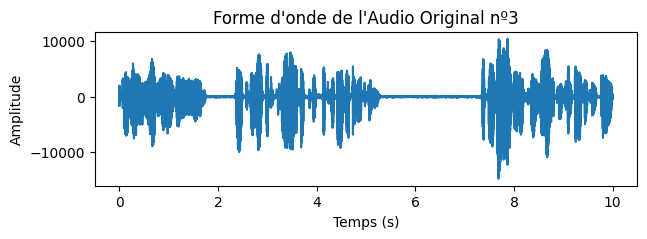

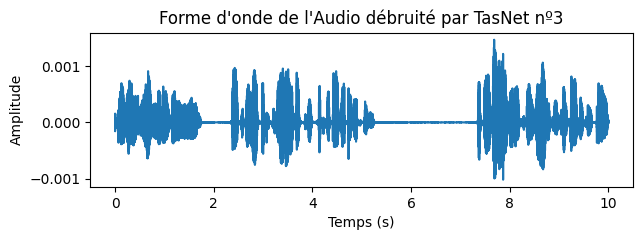

PESQ Score: 3.35
STOI Score: 0.97
---------------------------------------------






In [ ]:
# Initialisation du modèle

L, N = 40, 500
hidden_size, num_layers = 500, 4
model = TasNet(L, N, hidden_size, num_layers)
model = model.cuda()
model.load_state_dict(torch.load('/content/drive/MyDrive/denoising_dlts/checkpoints2/checkpoint_epoch_6.pt'))
model.eval()

# On traite 3 échantillons
for i in range(3):
    test_batch = next(iter(test_dataloader_tas))
    padded_mixture, mixture_lengths, padded_source = test_batch
    padded_mixture = padded_mixture.cuda()
    padded_source = padded_source.cuda()

    # Inférence
    with torch.no_grad():
        estimate_source = model(padded_mixture, mixture_lengths)

    selected_index = 0
    estimated_audio = estimate_source[selected_index].cpu().view(2, -1).numpy()
    bruit_audio = padded_mixture[selected_index].cpu().view(-1).numpy()
    original_audio = padded_source[selected_index].cpu().view(-1).numpy()
    original_audio = original_audio[:len(original_audio)//2]

    # On écoute les échantillons
    print(f"Audio bruité nº {i+1}:")
    _, _, bruit_rate, original_rate, _, _ = test_dataset_tas[i]
    ipd.display(ipd.Audio(bruit_audio, rate=original_rate))

    print(f"Audio original nº {i+1}:")
    _, _, bruit_rate, original_rate, _, _ = test_dataset_tas[i]
    ipd.display(ipd.Audio(original_audio, rate=original_rate))

    print(f"Audio débruité par TasNet nº{i+1}:")
    ipd.display(ipd.Audio(estimated_audio[0], rate=bruit_rate))

    # Forme d'onde

    plt.figure(figsize=(7, 2))
    plt.plot(np.linspace(0, len(bruit_audio) / original_rate, num=len(bruit_audio)), bruit_audio)
    plt.title(f"Forme d'onde de l'Audio Bruité nº{i+1}")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.show()

    plt.figure(figsize=(7, 2))
    plt.plot(np.linspace(0, len(original_audio) / original_rate, num=len(original_audio)), original_audio)
    plt.title(f"Forme d'onde de l'Audio Original nº{i+1}")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.show()

    bruit = estimated_audio[0]
    plt.figure(figsize=(7, 2))
    plt.plot(np.linspace(0, len(bruit) / bruit_rate, num=len(bruit)), bruit)
    plt.title(f"Forme d'onde de l'Audio débruité par TasNet nº{i+1}")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.show()

    # PESQ et STOI
    pesq_score = pesq(original_rate, original_audio, estimated_audio[0], 'nb')
    print(f"PESQ Score: {pesq_score:.2f}")

    stoi_score = stoi(original_audio, estimated_audio[0], original_rate)
    print(f"STOI Score: {stoi_score:.2f}")


    print("---------------------------------------------\n")
    print("\n\n")


On observe que les résultats obtenus pour TasNet sont très satisfaisants: on arrive à isoler quasi totalement la voix et le PESQ et STOI sont élevés. Cependant, nous avons remarqué que dans des cas concrets où le bruit de fond correspond à una voix de femme, quelques intérférences peuvent avoir lieu.

##Test - ConvTasNet


---------------------------------------------
Audio bruité:


Audio débruité par ConvTasNet:


Audio original:



Forme d'onde de l'audio


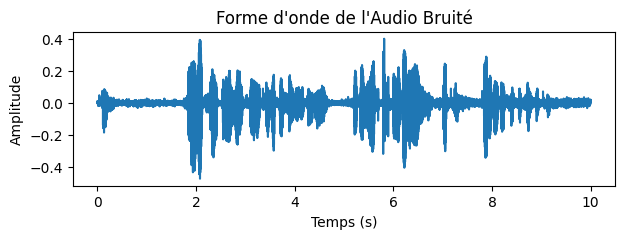

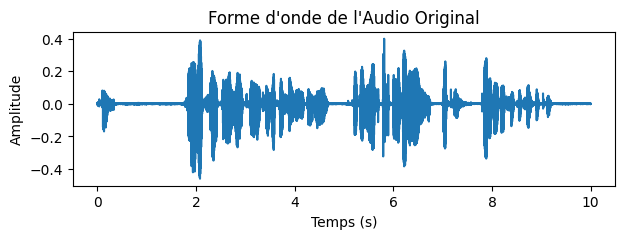

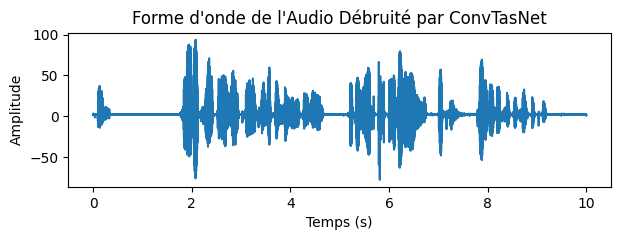

PESQ Score: 3.42
STOI Score: 0.99

---------------------------------------------
Audio bruité:


Audio débruité par ConvTasNet:


Audio original:



Forme d'onde de l'audio


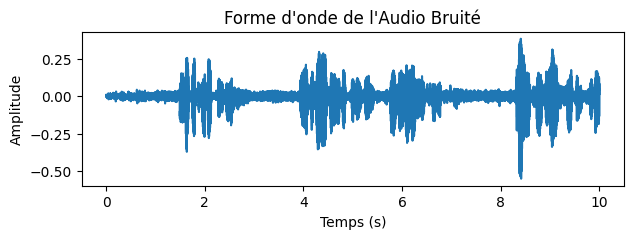

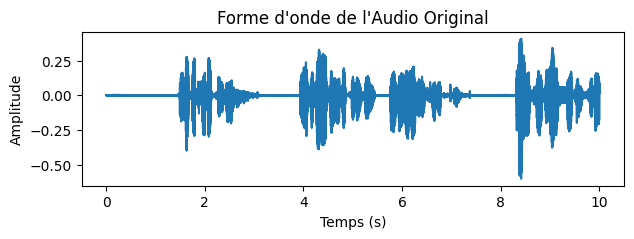

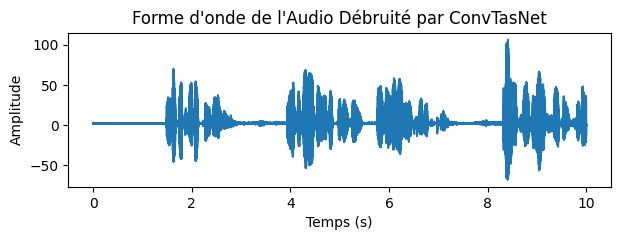

PESQ Score: 2.94
STOI Score: 0.96

---------------------------------------------
Audio bruité:


Audio débruité par ConvTasNet:


Audio original:



Forme d'onde de l'audio


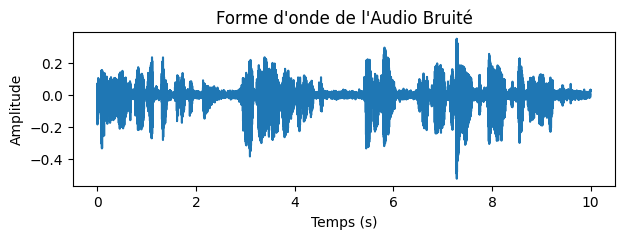

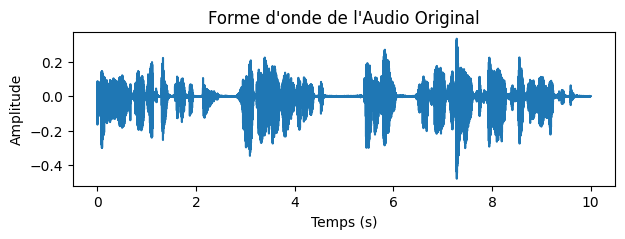

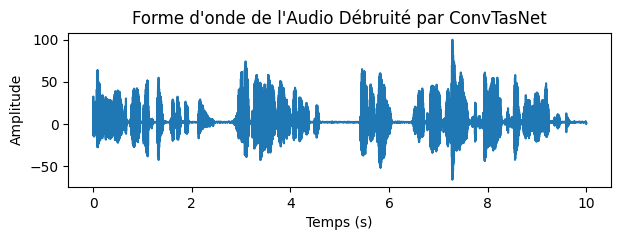

PESQ Score: 3.79
STOI Score: 0.99


In [ ]:
# On charge le checkpoint
path_to_checkpoint = '/content/drive/MyDrive/denoising_dlts/best_accuracy_checkpoint_conv.pt'
checkpoint = torch.load(path_to_checkpoint)
model = ConvTasNet(X=4, R=2, H=128, B=32)
model = model.cuda()
model.load_state_dict(checkpoint)
model.eval()

bruit_rate = 8000
original_rate = 8000
desired_indices = [10, 11, 12]

for i in desired_indices:
    print(f"\n---------------------------------------------")

    egs = test_dataloader_conv.dataset[i]
    egs['mix'] = egs['mix'].unsqueeze(0).cuda()  # Add batch dimension and move to CUDA

    # Inférence
    with torch.no_grad():
        estimate_source = model(egs['mix'])

    estimated_audio = estimate_source[0].cpu().numpy()
    noisy_audio = egs['mix'][0].cpu().view(-1).numpy()
    original_audio = egs['ref'][0].cpu().view(-1).numpy()

    # On écoute les échantillons:
    print(f"Audio bruité:")
    ipd.display(ipd.Audio(noisy_audio, rate=bruit_rate))

    print(f"Audio débruité par ConvTasNet:")
    ipd.display(ipd.Audio(estimated_audio, rate=bruit_rate))

    print(f"Audio original:")
    ipd.display(ipd.Audio(original_audio, rate=bruit_rate))

    # Forme d'onde:
    print("\nForme d'onde de l'audio")

    plt.figure(figsize=(7, 2))
    plt.plot(np.linspace(0, len(noisy_audio) / bruit_rate, num=len(noisy_audio)), noisy_audio)
    plt.title(f"Forme d'onde de l'Audio Bruité")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.show()

    plt.figure(figsize=(7, 2))
    plt.plot(np.linspace(0, len(original_audio) / bruit_rate, num=len(original_audio)), original_audio)
    plt.title(f"Forme d'onde de l'Audio Original")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.show()

    plt.figure(figsize=(7, 2))
    plt.plot(np.linspace(0, len(estimated_audio) / bruit_rate, num=len(estimated_audio)), estimated_audio)
    plt.title(f"Forme d'onde de l'Audio Débruité par ConvTasNet")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.show()



    # PESQ et STOI
    pesq_score = pesq(original_rate, original_audio, estimated_audio, 'nb')
    print(f"PESQ Score: {pesq_score:.2f}")

    stoi_score = stoi(original_audio, estimated_audio, original_rate)
    print(f"STOI Score: {stoi_score:.2f}")


On observe encore une fois que les résultats sont assez satisfaisants. De plus, le PESQ et STOI sont assez élevés, ce qui montre objectivement l'efficacité de notre modèle.